## TestCase: Check for the parameter numbers for each 1D-CNN blocks and proceed with deciding their total number

In [298]:
# Importing important packages
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from keras.src.regularizers import L2

In [299]:
# ATTENTION: RUN THIS BLOCK TO MOUNT THE GOOGLE DRIVE STORAGE WITHOUT DIRECT AUTHORISATION (EVADES PESKY AUTHORISATION MAIL SPAM)

# Mount the drive (Auto authorisation)
# from google.colab import auth
# auth.authenticate_user()
# from google.auth import default
# creds, _ = default()
# drive.mount('/content/drive')

- The block above contains three hyperparameter tuning layers for more control over future instances.
- Apart from that, numbers of blocks needed to be implemented is still a long shot.

- Considering the total number of trainable parameters, we need to do some modifications and research to find if the number makes sense.
-  Designing Bi-LSTM layer is not much of a concern since most of the idea of their efficiency is negligible and its worth relying on the trail and error ideology to test which architecture is actually reliable.
- Consider using dropouts:
    - before output fully connected layer.
    - after 1D CNN layer and before the flatten layer in 1D CNN block (if implemented)
    - after flatten layer in the classification overhead
- Consider using Batch Normalisation layers:
    - After the 1D convolution layer.
- Note: **Avoid using batch normalisation in RNN blocks!**

In [300]:
# CDSS Core function
'''
def Build_HybridModel(input_shape = (1000, 12), num_classes = 6):
  # L2 regulariser
  L2_Reg = tf.keras.regularizers.L2()

  # Input layer
  Input_Layer = layers.Input(shape = input_shape, name = "InputLayer")

  # Multi-Scale feature extraction using 1D CNN
  x = layers.Conv1D(64, kernel_size = 11, padding = "same", kernel_regularizer= L2_Reg)(Input_Layer)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.SpatialDropout1D(0.3)(x)
  x = layers.MaxPooling1D(pool_size = 2)(x)

  x = layers.Conv1D(128, kernel_size = 7, padding = "same", kernel_regularizer= L2_Reg)(Input_Layer)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.MaxPooling1D(pool_size = 2)(x)

  # Temporal Analysis using BiLSTM
  x = layers.Bidirectional(layers.LSTM(128, return_sequences = True, kernel_regularizer= L2_Reg))(x)
  x = layers.Dropout(0.4)(x)
  x = layers.Bidirectional(layers.LSTM(64, return_sequences = False, kernel_regularizer= L2_Reg))(x)

  # Classification Overhead
  x = layers.Dense(128, activation = "relu")(x)
  x = layers.Dropout(0.5)(x)

  # Output layer
  Output_Layer = layers.Dense(num_classes, activation = "sigmoid", name = "OutputLayer")(x)


  return tf.keras.Model(inputs = Input_Layer, outputs = Output_Layer, name = "Model")

# Build Model
model = Build_HybridModel()
'''

def Build_Model(input_shape = (1000, 12), num_classes = 5):

  # Input layer
  Input_Layer = layers.Input(shape = (1000,12), name = "Input_Layer")

  ##### Multi-scale label extraction using 1D CNN #####

  # block 1
  x = layers.Conv1D(filters = 264,
                    kernel_size = 11,
                    padding = "same")(Input_Layer)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.MaxPooling1D(pool_size = 2)(x)

  # block 2
  x = layers.Conv1D(filters = 128,
                    kernel_size = 7,
                    padding = "same")(Input_Layer)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.MaxPooling1D(pool_size = 2)(x)

  # block 3
  x = layers.Conv1D(filters = 64,
                    kernel_size = 5,
                    padding = "same")(Input_Layer)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.MaxPooling1D(pool_size = 2)(x)
  
  # block 4
  x = layers.Conv1D(filters = 32,
                    kernel_size = 3,
                    padding = "same")(Input_Layer)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.MaxPooling1D(pool_size = 2)(x)
  
  ##### Temporal Analysis using BiLSTM #####

  x = layers.Bidirectional(layers.LSTM(64, return_sequences = True, kernel_regularizer= None))(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Bidirectional(layers.LSTM(32, return_sequences = False, kernel_regularizer= None))(x)

  ##### Classification Overhead #####
  x = layers.Dense(128, activation = "relu")(x)
  x = layers.Dropout(0.4)(x)

  ##### Output layer #####
  Output_Layer = layers.Dense(num_classes, activation = "sigmoid", name = "OutputLayer")(x)


  return tf.keras.Model(inputs = Input_Layer, outputs = Output_Layer, name = "Model")


# Build Model
model = Build_Model()

In [301]:
# Subclass Custom Hamming Loss metric (Not using tensorflow addons here; version clash)

class HammingLoss(tf.keras.metrics.Metric):

    def __init__(self, name = "Hamming_loss", **kwargs):
        super(HammingLoss, self).__init__(name = name, **kwargs)
        self.total_mismatches = self.add_weight(name = "Total_mismatches", initializer = 'zeros', dtype = tf.float32)
        self.total_labels = self.add_weight(name = "Total_labels", initializer = 'zeros', dtype = tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # caste predictions and targets in tf.float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

        # Calculate mismatches
        mismatches = tf.cast((tf.math.count_nonzero(tf.math.not_equal(y_true, y_pred), axis=-1)), tf.float32)

        # Find number of labels and batch size
        num_label = tf.cast(tf.shape(y_true)[-1], tf.float32) # shape is (rows, columns) and columns = number of elements in array
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32) # shape is (rows, columns) and rows = batch size per array

        # Update number of mismatches and total labels count
        self.total_mismatches.assign_add(tf.reduce_sum(mismatches)) # reduce sum adds all the elements in an array (here, instance)
        self.total_labels.assign_add(batch_size * num_label) # total label count = number of labels x batch size per instance

    def result(self):
        return self.total_mismatches / self.total_labels # Hamming Loss formula

    def reset_state(self): # reset atttributes
        self.total_mismatches.assign(0.)
        self.total_labels.assign(0.)

In [302]:
# Subclass Custom Hamming score metric

class HammingScore(tf.keras.metrics.Metric):

    def __init__(self, name = "Hamming_score", **kwargs):
        super(HammingScore, self).__init__(name = name, **kwargs)
        self.total_mismatches = self.add_weight(name = "Total_mismatches", initializer = 'zeros', dtype = tf.float32)
        self.total_labels = self.add_weight(name = "Total_labels", initializer = 'zeros', dtype = tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # caste predictions and targets in tf.float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

        # Calculate mismatches
        mismatches = tf.cast((tf.math.count_nonzero(tf.math.not_equal(y_true, y_pred), axis=-1)), tf.float32)

        # Find number of labels and batch size
        num_label = tf.cast(tf.shape(y_true)[-1], tf.float32) # shape is (rows, columns) and columns = number of elements in array
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32) # shape is (rows, columns) and rows = batch size per array

        # Update number of mismatches and total labels count
        self.total_mismatches.assign_add(tf.reduce_sum(mismatches)) # reduce sum adds all the elements in an array (here, instance)
        self.total_labels.assign_add(batch_size * num_label) # total label count = number of labels x batch size per instance

    def result(self):
        return 1 - (self.total_mismatches / self.total_labels) # Hamming Score = 1 - Hamming loss

    def reset_state(self): # reset atttributes
        self.total_mismatches.assign(0.)
        self.total_labels.assign(0.)

In [303]:

# Model Compilation (loss function and optimiser)
model.compile(optimizer= tf.keras.optimizers.AdamW(learning_rate = 0.001),
              loss = tf.keras.losses.binary_focal_crossentropy,
              metrics = [tf.keras.metrics.FBetaScore(beta = 2.0, average = "weighted", threshold = 0.35),
                         tf.keras.metrics.AUC(curve = "PR", name = "PR-AUC", multi_label = True),
                         tf.keras.metrics.Recall(name = "recall", thresholds = 0.35),
                         tf.keras.metrics.Precision(name = "Precision"),
                         HammingLoss()])

In [304]:
model.summary()

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 1000, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 1000, 32)       │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 1000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_39 (MaxPooling1D) │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 500, 128)       │        49,664 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,157 (395.14 KB)

 Trainable params: 101,093 (394.89 KB)

 Non-trainable params: 64 (256.00 B)

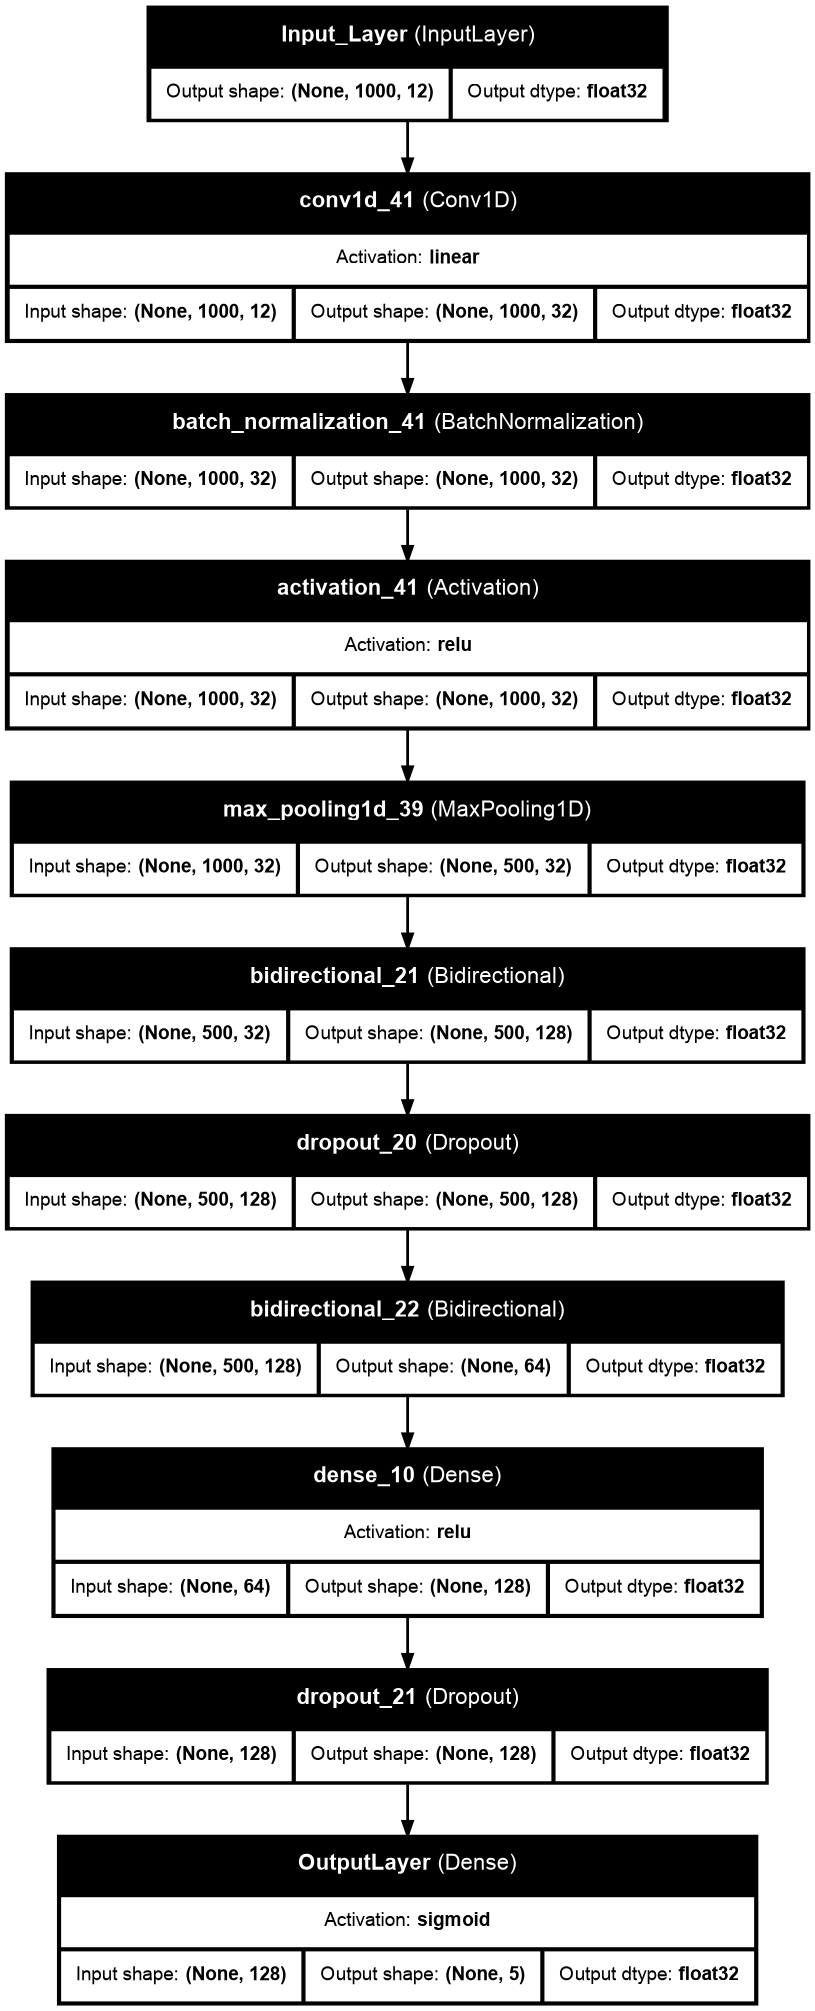

In [305]:
# Visualise The Model

tf.keras.utils.plot_model(model,
                          dpi = 100,
                          to_file = 'Final.png',
                          show_shapes = True,
                          show_dtype = True,
                          show_layer_names = True,
                          show_layer_activations = True)

## De-pickling training data

In [306]:
# load train dependant vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint2/X_TRAIN.pkl", "rb") as f:
    x_train = pickle.load(f)

In [307]:
# load train target vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint2/Y_TRAIN.pkl", "rb") as f:
    y_train = pickle.load(f)

In [308]:
# Check the data
print(f"The shape of dependent variables is {x_train.shape}.")
print(f"The shape of independent variables is {y_train.shape}.")

The shape of dependent variables is (12186, 1000, 12).
The shape of independent variables is (12186,).


In [309]:
# load test dependant vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint2/X_TEST.pkl", "rb") as f:
    x_test = pickle.load(f)

In [310]:
# load test target vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint2/Y_TEST.pkl", "rb") as f:
    y_test = pickle.load(f)

In [311]:
# Check the data
print(f"The shape of dependent variables is {x_test.shape}.")
print(f"The shape of independent variables is {y_test.shape}.")

The shape of dependent variables is (1519, 1000, 12).
The shape of independent variables is (1519,).


In [312]:
# load val dependant vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint2/X_VAL.pkl", "rb") as f:
    x_val = pickle.load(f)

In [313]:
# load val target vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint2/Y_VAL.pkl", "rb") as f:
    y_val = pickle.load(f)

The data seems to be correctly loaded!

## Trial Training Session

In [314]:
# x trial batch prep
trial_x_train = tf.cast(x_train, dtype=tf.float32) # for converting the numpy arrays into tensors of float32
print(f"the length for the both must be {len(trial_x_train)}")

# testing data preprocessing
trial_x_test = tf.cast(x_test, dtype = tf.float32)

# val data preprocessing
trial_x_val = tf.cast(x_val, dtype = tf.float32)
print(f"The datatype for the testing signal data is {type(trial_x_test)}")
print(f"\nLet us see the first entry:\n {trial_x_test[1]}")
print(f"\nTotal number of signals obtained from patients: {len(trial_x_test)}")

the length for the both must be 12186
The datatype for the testing signal data is <class 'tensorflow.python.framework.ops.EagerTensor'>

Let us see the first entry:
 [[ 0.0197401   0.28411135  0.27205467 ...  0.13033903 -0.08688466
  -0.15639248]
 [ 0.03749578  0.24365959  0.21192004 ...  0.11367655 -0.11108743
  -0.16832662]
 [ 0.01172353  0.19650194  0.19132221 ...  0.09987827 -0.1137758
  -0.17284344]
 ...
 [-0.01820286 -0.00605597  0.0040654  ...  0.10157418  0.00737948
   0.01523418]
 [ 0.08183096  0.09008075  0.01103054 ...  0.12941599  0.03722261
   0.04257413]
 [ 0.1611545   0.16443108  0.00710371 ...  0.12712333  0.08116429
   0.09363131]]

Total number of signals obtained from patients: 1519


**Considerations for target variables**

- Convert these pandas series into list.
- Setting up string lookup layer
- Setting up adapt layer (to create adapted vocabulary)
- Convert it

In [315]:
# analyse dtype of y_train
print(f"The data type of train target variables is {type(y_train)}")
print(f"The data type of test target variables is {type(y_test)}")

The data type of train target variables is <class 'pandas.core.series.Series'>
The data type of test target variables is <class 'pandas.core.series.Series'>


In [316]:
# convert into list
y_train = y_train.to_list()
y_test = y_test.to_list()
y_val = y_val.to_list()
print(f"The data type of train target variables is {type(y_train)}")
print(f"The data type of test target variables is {type(y_test)}")

The data type of train target variables is <class 'list'>
The data type of test target variables is <class 'list'>


In [317]:
# Analyse
print(y_train[1:10])
print(y_test[1:10])

[['NORM'], ['NORM'], ['NORM'], ['NORM'], ['NORM'], ['NORM'], ['STTC'], ['NORM'], ['NORM']]
[['NORM'], ['CD'], ['NORM'], ['NORM'], ['NORM'], ['NORM'], ['NORM'], ['CD'], ['STTC']]


In [318]:
# y trail batch split
trial_y_train = y_train
print(f"the length for the both must be {len(trial_y_train)}")
trial_y_test = y_test
print(f"the length for the both must be {len(trial_y_test)}")
trial_y_val = y_val
print(f"the length for the both must be {len(trial_y_val)}")

the length for the both must be 12186
the length for the both must be 1519
the length for the both must be 1484


In [319]:
# convert the list into a ragged tensor (handles non-rectangular data)
ragged_target_variable_train = tf.ragged.constant(trial_y_train)
ragged_target_variable_test = tf.ragged.constant(trial_y_test)
ragged_target_variable_val = tf.ragged.constant(trial_y_val)

In [320]:
# String Lookup layer
Str_Lookup_layer = layers.StringLookup(output_mode="multi_hot", num_oov_indices = 0)
Str_Lookup_layer.adapt(ragged_target_variable_train)
Str_Lookup_layer.get_vocabulary() # see the vocab

[np.str_('NORM'),
 np.str_('MI'),
 np.str_('STTC'),
 np.str_('CD'),
 np.str_('HYP')]

In [321]:
# Get the final converted form
trial_y_train = Str_Lookup_layer(ragged_target_variable_train)
trial_y_test = Str_Lookup_layer(ragged_target_variable_test)
trial_y_val = Str_Lookup_layer(ragged_target_variable_val)

In [322]:
trial_y_train = tf.cast(trial_y_train, tf.float32)
trial_y_test = tf.cast(trial_y_test, tf.float32)
trial_y_val = tf.cast(trial_y_val, tf.float32)

In [323]:
# test the first entry
print(trial_y_train[7]) # STTC entry
print(trial_y_test[7])
print(trial_y_val[7]) # NORM entry

tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)


## Model training runs

**Notes**

For Epochs:

- small dataset (<10k>) : epochs = 10-50
- medium dataset (10k-100k) : epochs = 20-200
- large datsets (100k+) : epochs = 50-500+
- fine-tuning/pre-trained models : epochs = 3-10

For batch size: (& ^gradient estimate stability & ^convergence & !Generaliastion)

- standard/baseline = 32
- Image Classification  = 32/64/128
- NLP = ~16-32
- Limited Memory/Small dataset = 8/16

In [324]:
current_class_weights = {0:0.017,
                         1:0.035,
                         2:0.035,
                         3:0.037,
                         4:0.066}

In [325]:
# Set call backs

Callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = "val_Precision", patience = 12, restore_best_weights = True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5)
]

In [326]:
# train the model

History = model.fit(
    x = trial_x_train,
    y = trial_y_train,
    validation_data = (trial_x_val, trial_y_val),
    epochs = 100,
    batch_size = 32,
    callbacks = Callbacks
)

Epoch 1/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 123ms/step - Hamming_loss: 0.2598 - PR-AUC: 0.2545 - Precision: 0.4676 - fbeta_score: 0.6300 - loss: 0.1399 - recall: 0.8919 - val_Hamming_loss: 0.2584 - val_PR-AUC: 0.2592 - val_Precision: 0.4789 - val_fbeta_score: 0.6216 - val_loss: 0.1375 - val_recall: 0.9047 - learning_rate: 0.0010
Epoch 2/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - Hamming_loss: 0.2580 - PR-AUC: 0.2566 - Precision: 0.4753 - fbeta_score: 0.6352 - loss: 0.1383 - recall: 0.9112 - val_Hamming_loss: 0.2581 - val_PR-AUC: 0.2605 - val_Precision: 0.4540 - val_fbeta_score: 0.6210 - val_loss: 0.1374 - val_recall: 0.9042 - learning_rate: 0.0010
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - Hamming_loss: 0.2575 - PR-AUC: 0.2560 - Precision: 0.4733 - fbeta_score: 0.6344 - loss: 0.1381 - recall: 0.9112 - val_Hamming_loss: 0.2574 - val_PR-AUC: 0.2620 - val_Precision: 0.4615 - val_fbeta_score: 0.6209 - val_loss: 0.1372 - val_recall: 0.9042 - learning_rate: 0.0010
Epoc

In [327]:
# evaluate the model
Evaluation_result = model.evaluate(
    x = trial_x_test,
    y = trial_y_test,
    batch_size = 32
)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - Hamming_loss: 0.2581 - PR-AUC: 0.2574 - Precision: 0.4394 - fbeta_score: 0.6191 - loss: 0.1383 - recall: 0.8992


In [328]:
results = model.predict(x = trial_x_test[83:84])
print(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
[[0.4834962  0.38457453 0.4003929  0.3804999  0.31623295]]


> Results: **The test run was successful. Now we will adapt this pipeline to our cloud instance.**